In [1]:
%pylab inline
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


## We are going to be exploring bootstrapping using the empirical distribution. 

As a reminder:
$$ \textrm{Var}_F(T_n) \approx \textrm{Var}_{\hat{F_n}}(T_n) \approx v_{boot}$$
There are two approximations going on here.  To compute $v_{boot}$:

For i in B:
1. Draw $X_1^*, X_2^*, ..., X_n^* \sim \hat{F_n}$
2. Compute $T_{n,i}^* = g(X_1^*, X_2^*, ..., X_n^*)$

Now that you have $T_{n,1}^*,T_{n,2}^*,...,T_{n,B}^*$, compute
$$v_{boot} = \frac{1}{B} \sum_{j=1}^B \left( T_{n,j}^* - \frac{1}{B} \sum_{k=1}^B T_{n,k}^* \right)^2$$

We have 3 methods for constructing confidence intervals
1. *The Normal Interval* is simple, but only correct to use if $T_n$ is approximately normal. Then $\hat{se} = \sqrt{v_{boot}}$ and the confidence interval is $$ C_n = (T_n - z_{\alpha/2}\hat{se}, T_n + z_{\alpha/2}\hat{se})$$
2. *Pivot Interval*.
   
   Let $\theta = T(F)$, $\hat{\theta} = T(\hat{F_n})$
   
   Let $\hat{\theta}_{n,1}^*, \hat{\theta}_{n,2}^*,..., \hat{\theta}_{n,B}^*$ be the bootstrap replications of $\hat{\theta}$.  
   
   Let $\hat{\theta}^*_{\beta}$ denote the $\beta^{\textrm{th}}$ sample quartile. 
   $$ C_n = (2\hat{\theta_n} - \hat{\theta}^*_{1-\alpha/2}, 2\hat{\theta_n} - \hat{\theta}^*_{\alpha/2}) $$
3. *Percentile Interval* $$ C_n = (\hat{\theta}^*_{\alpha/2}, \hat{\theta}^*_{1-\alpha/2} )$$

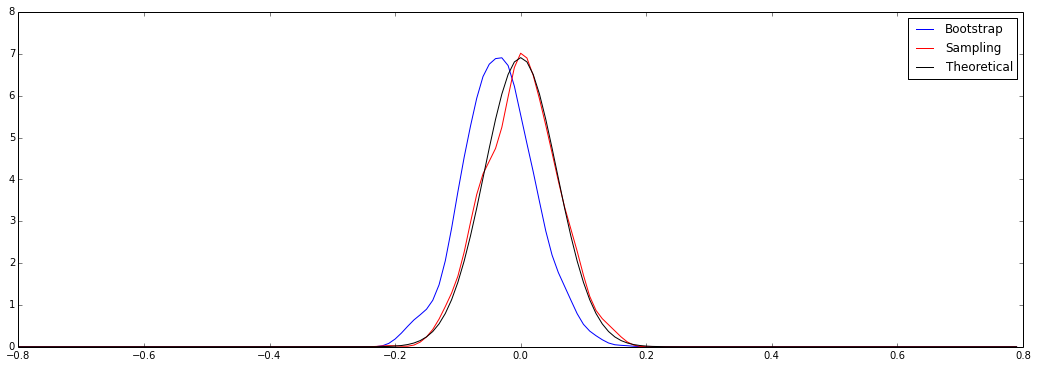

In [11]:
N = 300
B = 1000

x = normal(size=N)
boot_means = [random.choice(x, size=N, replace=True).mean() for i in range(B)]

sampled_means = [normal(size=N).mean() for i in range(B)]

boot_density = stats.kde.gaussian_kde(boot_means)
sampled_density = stats.kde.gaussian_kde(sampled_means)

figsize(18, 6)
y = arange(-0.8, 0.8, .01)
plot(y, boot_density(y), 'b', label="Bootstrap")
plot(y, sampled_density(y), 'r', label="Sampling")
plot(y, stats.norm.pdf(y,0,1.0/sqrt(N)), 'k', label="Theoretical")
legend()

### Chapter 8, #2
Conduct a simulation to compare the various bootstrap confidence interval methods. Let $n=50$ and let $T(F)=\int(x-\mu)^3dF(x) / \sigma^3$ be the skewness. Draw $Y_1, Y_2, ... Y_n \sim N(0,1)$ and set $X_i = e^{Y_i}$.  Construct the 95 percent intervals for $T(F)$ from the data $X_1, X_2, ... X_n$. Repeat this whole thing many times and estimate the true coverage.

First, let's write a function that let us estimate the skewedness.

In [12]:
# Of course something has been written already, so we could use:
# from scipy.stats import skew as skewness
def skewness(sample):
    mu = mean(sample)
    third_moment_about_mean = sum((sample-mu)**3)/float(len(sample))
    sigma3 = std(sample)**3
    return third_moment_about_mean/sigma3

def boot(sample_data, statistic_func, N=None, B=1000):
    N = N or len(sample_data)
    bootstrap_data = []
    for i in range(B):
        resampled_data = random.choice(sample_data, size=N, replace=True)
        resampled_stat = statistic_func(resampled_data)
        bootstrap_data.append(resampled_stat)
    return bootstrap_data

def normal_interval(alpha, theta, boot_data):
    se = std(boot_data)
    z = stats.norm.ppf(1-alpha/2)
    return (theta - se*z, theta + se*z)

def pivot_interval(alpha, theta, bootdata):
    return (2*theta - percentile(bootdata, 100*(1-alpha/2.0)), 2*theta - percentile(bootdata, 100*alpha/2.0))

def percentile_interval(alpha, bootdata):
    return (percentile(bootdata, 100*alpha/2.0), percentile(bootdata, 100.0*(1-alpha/2.0)))
    

In [23]:
random.seed(0)

runs = 500
alpha = 0.05
true_value = 6.1848771386325572
func = skewness # variables and arguments can be set to functions

N = 50
B = 10000

normal_capture_count = 0
pivot_capture_count = 0
percentile_capture_count = 0

for i in range(runs):
    data = exp(normal(size=N)) # the default values for mean and variance are the standard normal
    theta = func(data)
    bootdata = boot(data, func, N, B)
    
    a,b = normal_interval(alpha, theta, bootdata)
    if a <= true_value <= b:
        normal_capture_count += 1
        
    a,b = pivot_interval(alpha, theta, bootdata)
    if a <= true_value <= b:
        pivot_capture_count += 1
        
    a,b = percentile_interval(alpha, bootdata)
    if a <= true_value <= b:
        percentile_capture_count += 1
        
    if (i+1)%50 == 0:
        print "Finished run %d" % (i+1)
        

Finished run 50
Finished run 100
Finished run 150
Finished run 200
Finished run 250
Finished run 300
Finished run 350
Finished run 400
Finished run 450
Finished run 500


In [24]:
normal_capture = float(normal_capture_count)/runs
pivot_capture = float(pivot_capture_count)/runs
percentile_capture = float(percentile_capture_count)/runs
        
print "Supposed: %.3f\nNormal: %.3f\nPivot: %.3f\nPercentile: %.3f" % (1-alpha, normal_capture, pivot_capture, percentile_capture)

Supposed: 0.950
Normal: 0.400
Pivot: 0.368
Percentile: 0.300


In [17]:
_mu = sqrt(e)
_sigma = sqrt(e**2-e)

_num = _mu**9 - 3*_mu**5 + 2*_mu**3
_den = _sigma**3

_num/_den

6.1848771386325572

In [21]:
for i in range(1,9):
    print i, skewness(exp(normal(size=10**i)))

1 1.63820639099
2 2.70077782089
3 5.70857376582
4 5.82184964254
5 6.94182273591
6 6.20437371151
7 6.50476339665
8 6.18860954964
